<a href="https://colab.research.google.com/github/felipe0907/Parcial2_IA/blob/main/Parcial%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix,
    classification_report )
from sklearn.model_selection import ParameterGrid



Dimensiones:
  Train: (32561, 15)
  Test : (16280, 15)

Split del 'test' en 50/50 (validación y prueba):
  Validación: (8140, 15)
  Prueba    : (8140, 15)

=== Train: Resumen rápido ===
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   

       marital-status         occupation   relationship   race   sex  \
0       Never-married       Adm-clerical  Not-in-family  White  Male   
1  Married-civ-spouse    Exec-managerial        Husband  White  Male   
2            Divorced  Handlers-cleaners  Not-in-family  White  Male   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50

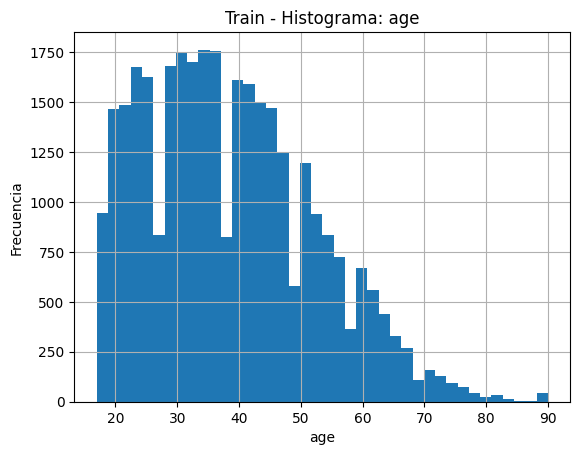

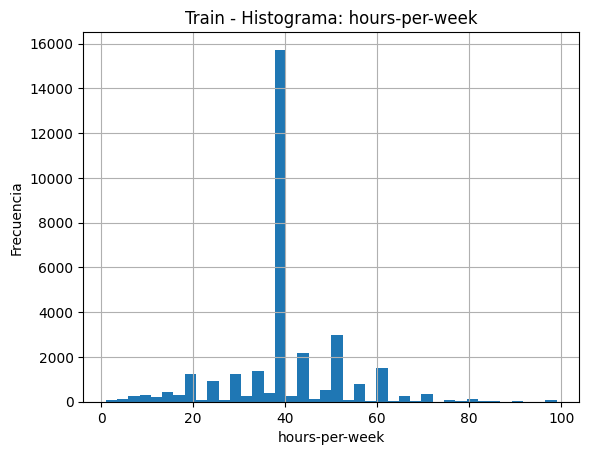

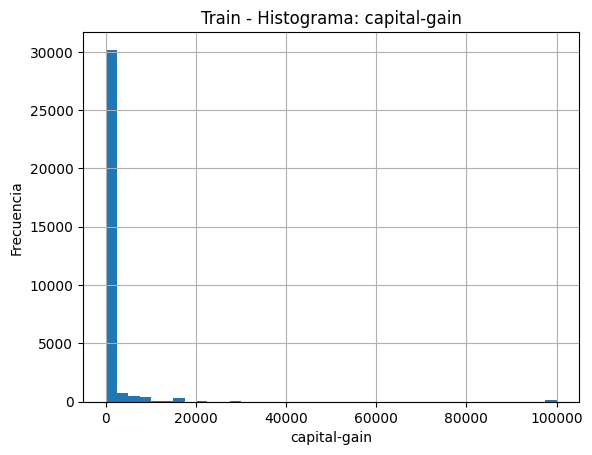

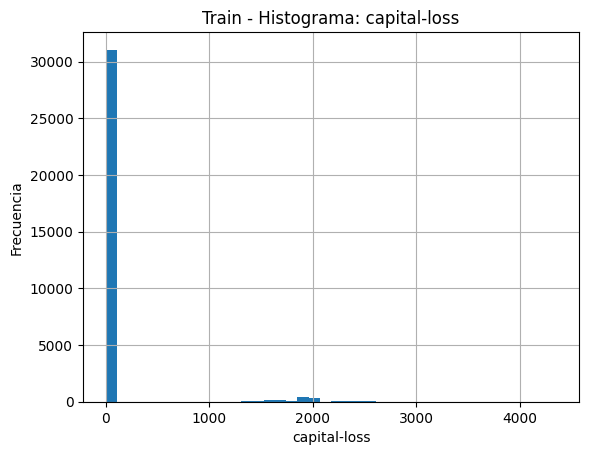

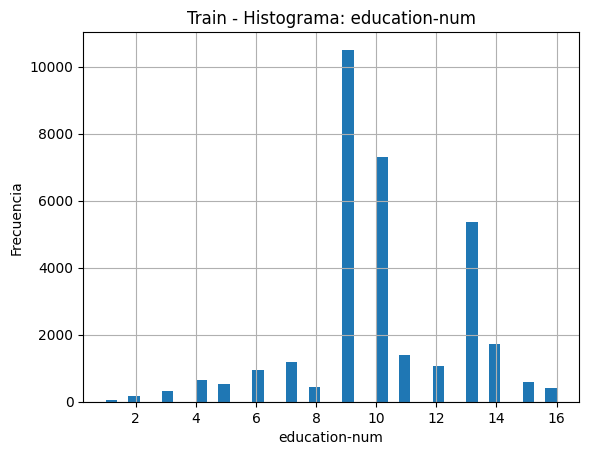

<Figure size 640x480 with 0 Axes>

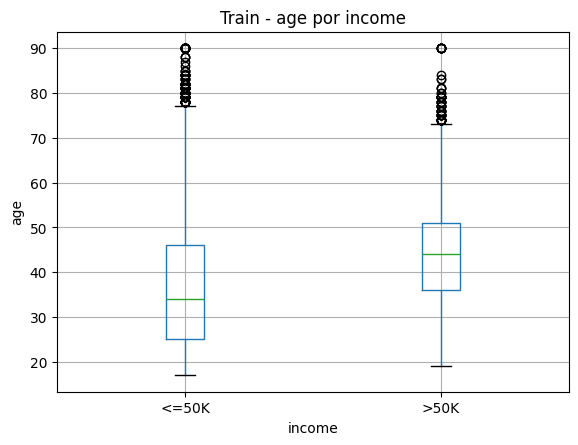

<Figure size 640x480 with 0 Axes>

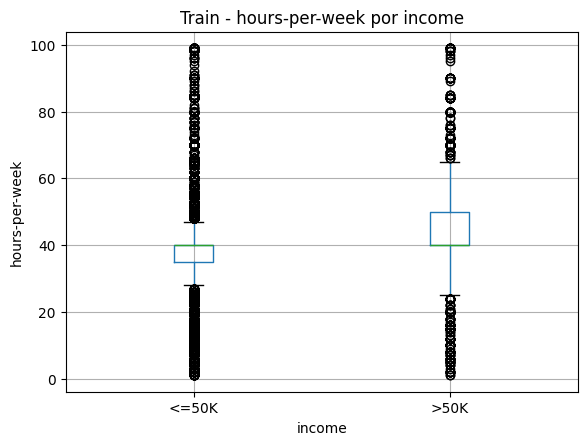

<Figure size 640x480 with 0 Axes>

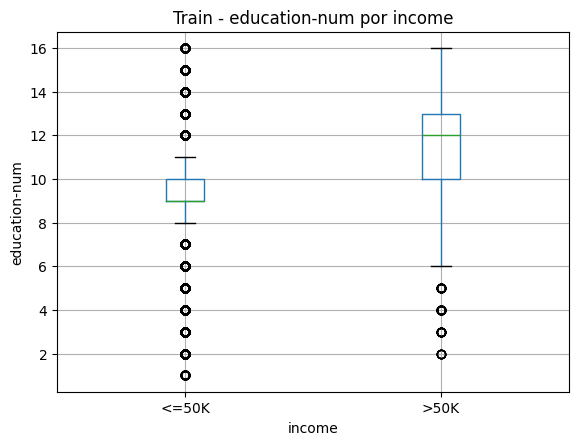

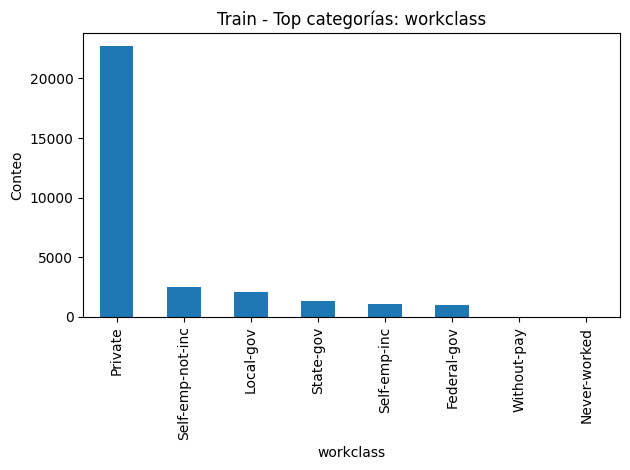

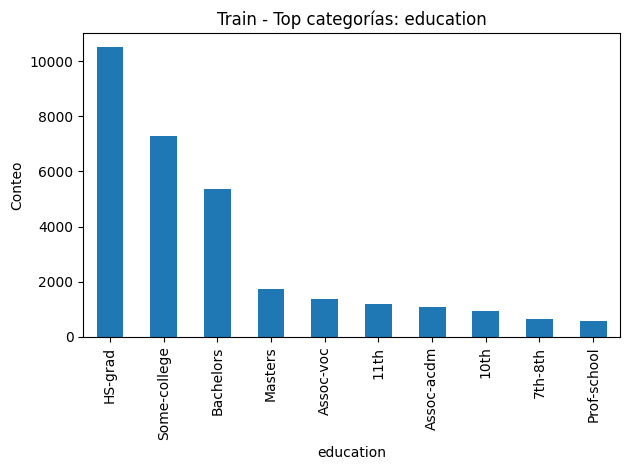

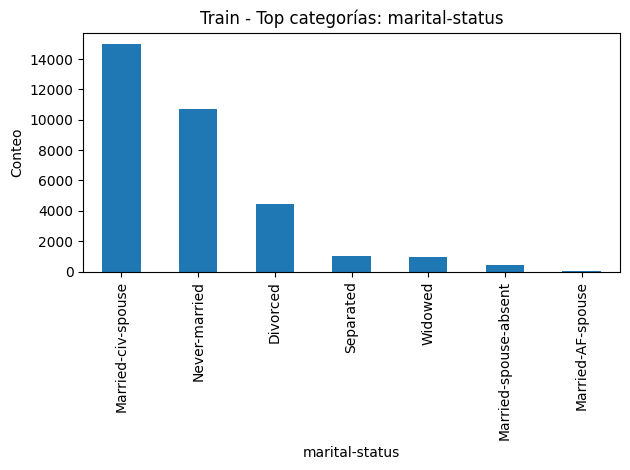

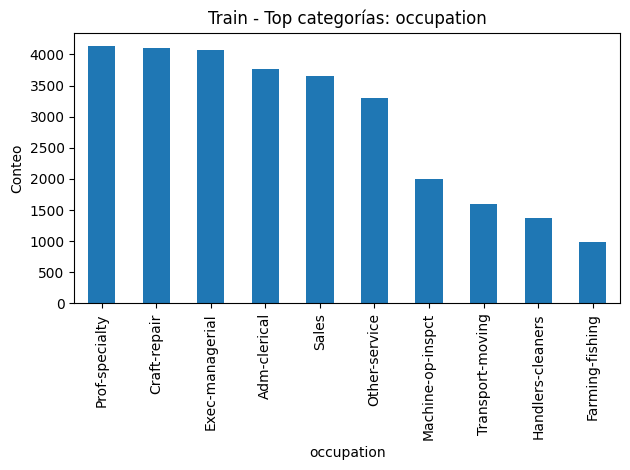

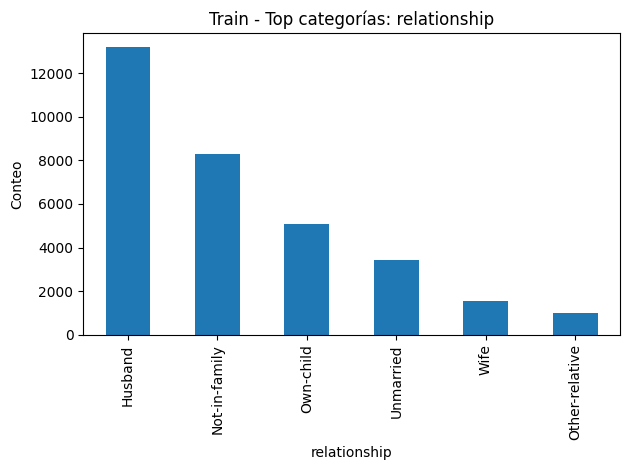

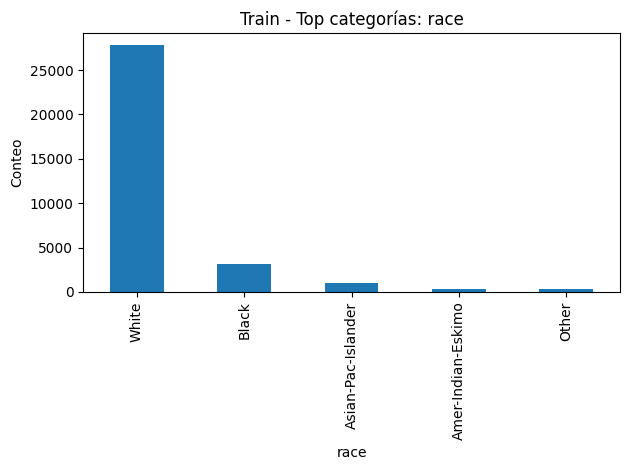

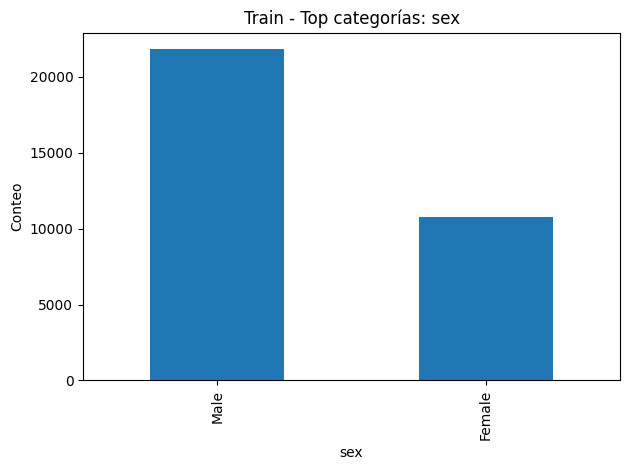

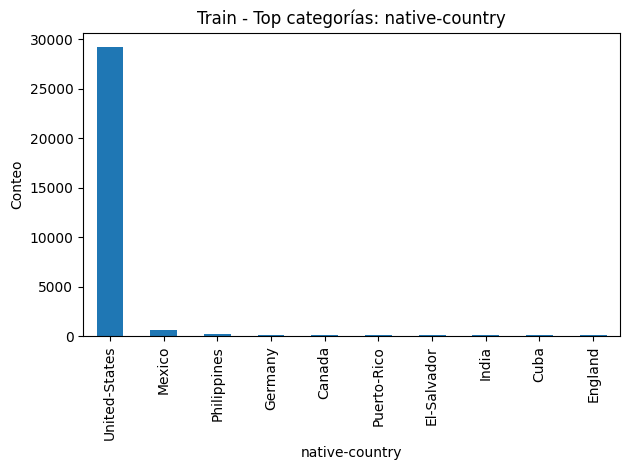


Columnas numéricas: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Columnas categóricas: ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

Ejemplo de primeras 20 columnas finales:
['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay', 'marital-status_Divorced', 'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse', 'marital-status_Married-spouse-absent', 'marital-status_Never-married', 'marital-status_Separated']

Dimensiones post-preprocesamiento:
  X_train_p: (32561, 89)
  X_val_p  : (8140, 89)
  X_test_p : (8140, 89)

Preprocessor guardado en 'adult_preprocessor.joblib'


In [12]:

# -----------------------
# 0. Configuración general
# -----------------------
SEED = 42
np.random.seed(SEED)

DATA_DIR = "/content"
TRAIN_FILE = os.path.join(DATA_DIR, "/content/adult.data")
TEST_FILE  = os.path.join(DATA_DIR, "/content/adult.test")

COLUMN_NAMES = [
    "age","workclass","fnlwgt","education","education-num","marital-status",
    "occupation","relationship","race","sex","capital-gain","capital-loss",
    "hours-per-week","native-country","income"
]

TARGET_COL = "income"

# -------------------------------------------------
# 1. Carga y limpieza ligera
# -------------------------------------------------
def load_adult(train_path, test_path):
    train = pd.read_csv(train_path, header=None, names=COLUMN_NAMES,
                        na_values="?", skipinitialspace=True)
    test  = pd.read_csv(test_path, header=0, names=COLUMN_NAMES,
                        na_values="?", skipinitialspace=True, comment='|')
    test[TARGET_COL] = test[TARGET_COL].apply(lambda s: re.sub(r"\.", "", str(s)).strip())
    return train, test

train_df, test_df = load_adult(TRAIN_FILE, TEST_FILE)

print("Dimensiones:")
print("  Train:", train_df.shape)
print("  Test :", test_df.shape)

# ------------------------------------------------------------
# 2. Split 50/50
# ------------------------------------------------------------
test_val_df, test_final_df = train_test_split(
    test_df,
    test_size=0.5,
    random_state=SEED,
    stratify=test_df[TARGET_COL]
)

print("\nSplit del 'test' en 50/50 (validación y prueba):")
print("  Validación:", test_val_df.shape)
print("  Prueba    :", test_final_df.shape)

# ---------------------------------------------------------
# 3. EDA
# ---------------------------------------------------------
def quick_eda(df, title_prefix="Train"):
    print(f"\n=== {title_prefix}: Resumen rápido ===")
    print(df.head(3))
    print("\nInfo:")
    print(df.info())
    print("\nValores faltantes por columna:")
    print(df.isna().sum().sort_values(ascending=False))
    print("\nDistribución del target:")
    print(df[TARGET_COL].value_counts(normalize=True).rename("proportion"))

    # Numéricas y categóricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols     = [c for c in df.columns if c not in numeric_cols + [TARGET_COL]]

    # Histograma de numéricas
    for col in ["age", "hours-per-week", "capital-gain", "capital-loss", "education-num"]:
        if col in df.columns:
            plt.figure()
            df[col].hist(bins=40)
            plt.title(f"{title_prefix} - Histograma: {col}")
            plt.xlabel(col); plt.ylabel("Frecuencia")
            plt.show()

    # Boxplots por target (siempre sobre train)
    for col in ["age", "hours-per-week", "education-num"]:
        if col in df.columns:
            plt.figure()
            df[[col, TARGET_COL]].boxplot(by=TARGET_COL)
            plt.title(f"{title_prefix} - {col} por {TARGET_COL}")
            plt.suptitle("")
            plt.xlabel(TARGET_COL); plt.ylabel(col)
            plt.show()

    # Top niveles de categorías
    for col in ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]:
        if col in df.columns:
            plt.figure()
            df[col].value_counts().head(10).plot(kind="bar")
            plt.title(f"{title_prefix} - Top categorías: {col}")
            plt.xlabel(col); plt.ylabel("Conteo")
            plt.tight_layout()
            plt.show()

quick_eda(train_df, title_prefix="Train")

# -------------------------------------------------------------------
# 4. Preprocesamiento sin data leakage (ajuste SOLO con entrenamiento)
# -------------------------------------------------------------------
# a) Definición de variables
#    - Eliminamos 'education' (texto) por redundante con 'education-num'
drop_cols = ["education"]
x_cols = [c for c in train_df.columns if c not in drop_cols + [TARGET_COL]]

def split_Xy(df, features, target):
    X = df[features].copy()
    y = df[target].copy()
    # Normalizamos la etiqueta a binaria 0/1
    # Adult: "<=50K" → 0 ;  ">50K" → 1
    y = y.apply(lambda s: 1 if str(s).strip() == ">50K" else 0)
    return X, y

X_train, y_train = split_Xy(train_df, x_cols, TARGET_COL)
X_val,   y_val   = split_Xy(test_val_df, x_cols, TARGET_COL)
X_test,  y_test  = split_Xy(test_final_df, x_cols, TARGET_COL)

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X_train.columns if c not in numeric_features]

print("\nColumnas numéricas:", numeric_features)
print("Columnas categóricas:", categorical_features)

# b) Pipelines por tipo
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# c) Ajuste SOLO con entrenamiento (evitamos leakage)
preprocessor.fit(X_train)

# d) Transformación consistente en train/val/test
X_train_p = preprocessor.transform(X_train)
X_val_p   = preprocessor.transform(X_val)
X_test_p  = preprocessor.transform(X_test)

# e) nombres de columnas resultantes
ohe = preprocessor.named_transformers_["cat"]["onehot"]
ohe_cols = ohe.get_feature_names_out(categorical_features)
final_feature_names = list(numeric_features) + list(ohe_cols)
print(final_feature_names[:20])

print("\nDimensiones post-preprocesamiento:")
print("  X_train_p:", X_train_p.shape)
print("  X_val_p  :", X_val_p.shape)
print("  X_test_p :", X_test_p.shape)

#  Guardar el preprocessor para usar exactamente la misma transformación con modelos/producción
joblib.dump(preprocessor, "adult_preprocessor.joblib")
print("\nPreprocessor guardado en 'adult_preprocessor.joblib'")

[VAL] params={'C': 0.1, 'class_weight': None}  AUC=0.9011  F1@0.5=0.6425
[VAL] params={'C': 0.1, 'class_weight': 'balanced'}  AUC=0.9011  F1@0.5=0.6697
[VAL] params={'C': 1.0, 'class_weight': None}  AUC=0.9008  F1@0.5=0.6440
[VAL] params={'C': 1.0, 'class_weight': 'balanced'}  AUC=0.9007  F1@0.5=0.6689
[VAL] params={'C': 3.0, 'class_weight': None}  AUC=0.9006  F1@0.5=0.6430
[VAL] params={'C': 3.0, 'class_weight': 'balanced'}  AUC=0.9005  F1@0.5=0.6682

Mejor config (por AUC luego F1@0.5): {'C': 0.1, 'class_weight': None}


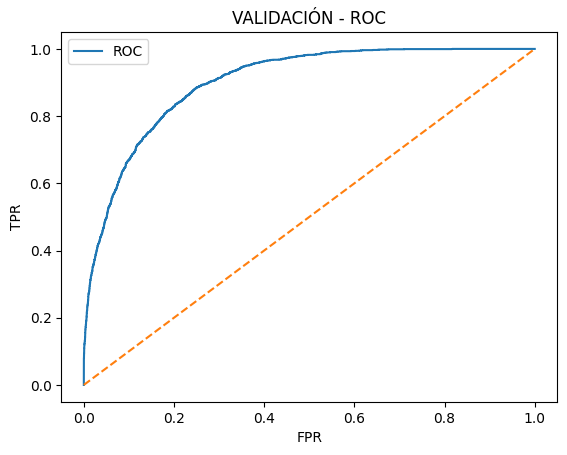

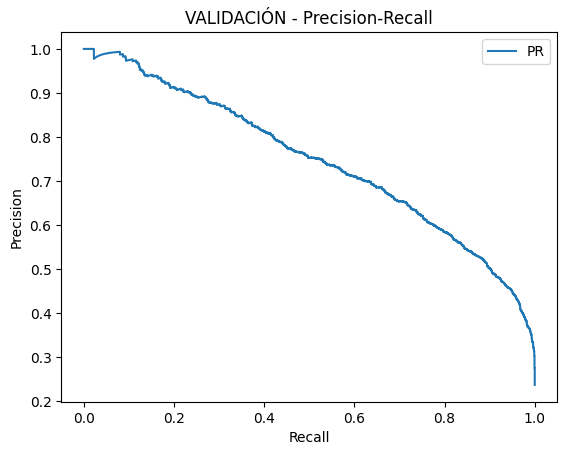


Umbral óptimo por F1 en VALIDACIÓN: thr=0.3380  F1=0.6817

=== VALIDACIÓN (0.5) @thr=0.500 ===
Accuracy : 0.8472
Precision: 0.7180
Recall   : 0.5814
F1       : 0.6425
ROC AUC  : 0.9011

Matriz de confusión:
[[5778  439]
 [ 805 1118]]

=== VALIDACIÓN (thr_opt) @thr=0.338 ===
Accuracy : 0.8372
Precision: 0.6336
Recall   : 0.7374
F1       : 0.6816
ROC AUC  : 0.9011

Matriz de confusión:
[[5397  820]
 [ 505 1418]]

Reporte de clasificación (thr=0.5):
              precision    recall  f1-score   support

           0     0.8777    0.9294    0.9028      6217
           1     0.7180    0.5814    0.6425      1923

    accuracy                         0.8472      8140
   macro avg     0.7979    0.7554    0.7727      8140
weighted avg     0.8400    0.8472    0.8413      8140


=== EVALUACIÓN EN TEST ===

=== TEST (0.5) @thr=0.500 ===
Accuracy : 0.8561
Precision: 0.7420
Recall   : 0.5996
F1       : 0.6632
ROC AUC  : 0.9068

Matriz de confusión:
[[5816  401]
 [ 770 1153]]

=== TEST (thr_opt) @th

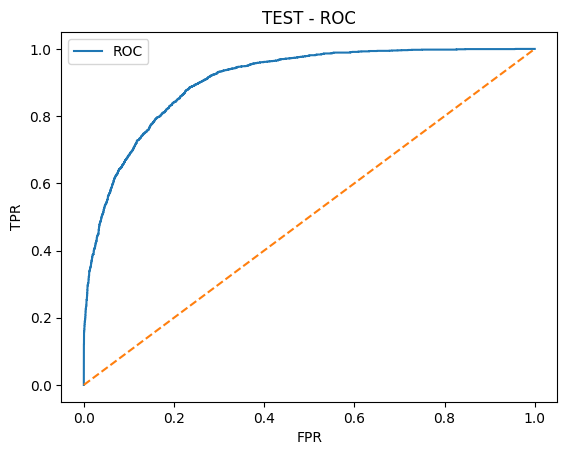

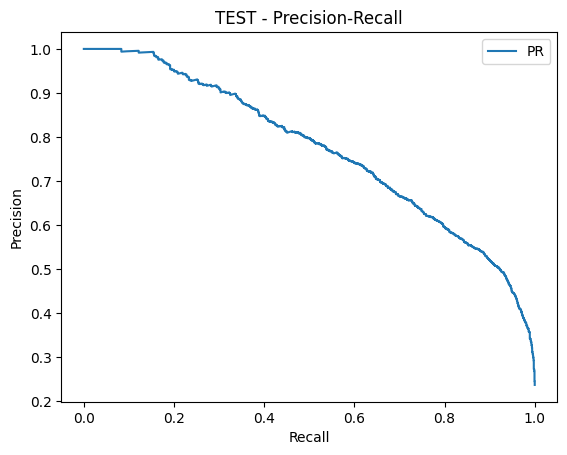


Reporte de clasificación TEST (thr=0.5):
              precision    recall  f1-score   support

           0     0.8831    0.9355    0.9085      6217
           1     0.7420    0.5996    0.6632      1923

    accuracy                         0.8561      8140
   macro avg     0.8125    0.7675    0.7859      8140
weighted avg     0.8497    0.8561    0.8506      8140


Top 20 coeficientes NEGATIVOS (predicen <=50K):
relationship_Own-child                 -0.882185
occupation_Farming-fishing             -0.847377
marital-status_Never-married           -0.795946
occupation_Other-service               -0.775350
relationship_Other-relative            -0.536011
native-country_Columbia                -0.473330
occupation_Handlers-cleaners           -0.456654
native-country_South                   -0.436539
native-country_Mexico                  -0.416339
occupation_Priv-house-serv             -0.409956
sex_Female                             -0.390711
native-country_Vietnam                 -0.3

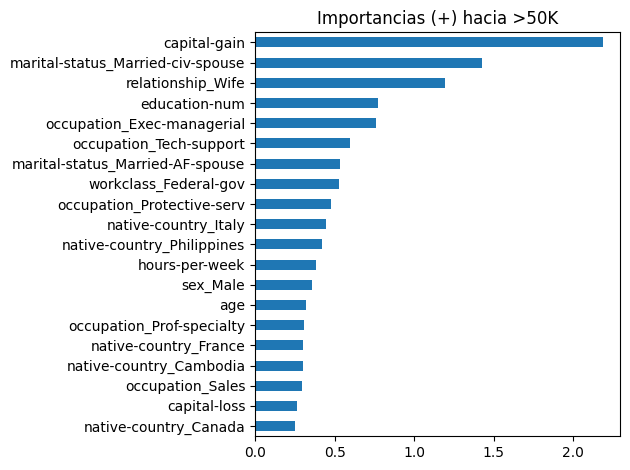

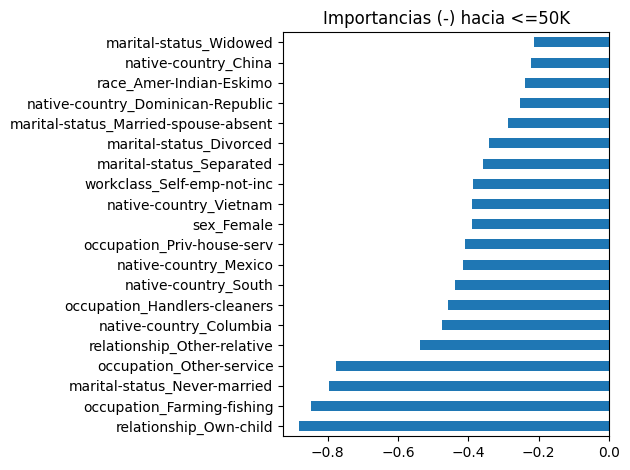

In [13]:



# ---------------------------------------------------------
# 1) Utilidades de evaluación
# ---------------------------------------------------------
def eval_metrics(y_true, y_prob, threshold=0.5, title_prefix="VAL"):
    y_pred = (y_prob >= threshold).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auc  = roc_auc_score(y_true, y_prob)

    print(f"\n=== {title_prefix} @thr={threshold:.3f} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1       : {f1:.4f}")
    print(f"ROC AUC  : {auc:.4f}")
    print("\nMatriz de confusión:")
    print(confusion_matrix(y_true, y_pred))
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "auc":auc}

def plot_roc_pr(y_true, y_prob, title_prefix="VAL"):
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"{title_prefix} - ROC")
    plt.legend()
    plt.show()

    # PR
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.figure()
    plt.plot(recall, precision, label="PR")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} - Precision-Recall")
    plt.legend()
    plt.show()

def best_threshold_by_f1(y_true, y_prob):
    precision, recall, thresh = precision_recall_curve(y_true, y_prob)
    # evitar extremos (PR devuelve un punto más que thresholds)
    thresholds = np.r_[0.0, thresh, 1.0]
    f1s = 2 * (precision * recall) / np.where((precision + recall)==0, 1, (precision + recall))
    best_idx = np.nanargmax(f1s)
    return float(thresholds[best_idx]), float(f1s[best_idx])

# ---------------------------------------------------------
# 2) Grid simple de modelos (balanced vs no balanced, C)
# ---------------------------------------------------------
grids = [
    {"class_weight":[None], "C":[0.1, 1.0, 3.0]},
    {"class_weight":[ "balanced"], "C":[0.1, 1.0, 3.0]},
]

def train_and_validate(Xtr, ytr, Xva, yva, grids, title="LogReg"):
    results = []
    for params in ParameterGrid({"class_weight":[None,"balanced"], "C":[0.1,1.0,3.0]}):
        try:
            clf = LogisticRegression(
                penalty="l2",
                C=params["C"],
                class_weight=params["class_weight"],
                solver="lbfgs",
                max_iter=200,
                random_state=SEED,
                n_jobs=None
            )
            clf.fit(Xtr, ytr)
            yva_prob = clf.predict_proba(Xva)[:,1]
            # Usamos AUC y F1@0.5 para ranking preliminar
            auc = roc_auc_score(yva, yva_prob)
            f1  = f1_score(yva, (yva_prob>=0.5).astype(int))
            results.append({"params":params, "auc":auc, "f1@0.5":f1, "model":clf, "yva_prob":yva_prob})
            print(f"[VAL] params={params}  AUC={auc:.4f}  F1@0.5={f1:.4f}")
        except Exception as e:
            print("Error con params", params, "->", e)
    # Ordenar por AUC y luego por F1
    results = sorted(results, key=lambda d: (d["auc"], d["f1@0.5"]), reverse=True)
    best = results[0]
    print("\nMejor config (por AUC luego F1@0.5):", best["params"])
    return best, results

best, all_results = train_and_validate(X_train_p, y_train, X_val_p, y_val, grids)

# ---------------------------------------------------------
# 3) Métricas, curvas y UMBRAL óptimo en Validación
# ---------------------------------------------------------
y_val_prob = best["yva_prob"]
plot_roc_pr(y_val, y_val_prob, title_prefix="VALIDACIÓN")

# Umbral por F1 en validación
thr_opt, f1_opt = best_threshold_by_f1(y_val, y_val_prob)
print(f"\nUmbral óptimo por F1 en VALIDACIÓN: thr={thr_opt:.4f}  F1={f1_opt:.4f}")

# Reporte @0.5 y @thr_opt
_ = eval_metrics(y_val, y_val_prob, threshold=0.5,   title_prefix="VALIDACIÓN (0.5)")
_ = eval_metrics(y_val, y_val_prob, threshold=thr_opt, title_prefix="VALIDACIÓN (thr_opt)")

print("\nReporte de clasificación (thr=0.5):")
print(classification_report(y_val, (y_val_prob>=0.5).astype(int), digits=4))

# ---------------------------------------------------------
# 4) Reentrenar en Train+Val y evaluar en Test con thr_opt
# ---------------------------------------------------------
# Concatenamos matrices ya preprocesadas (NO re-ajustamos el preprocessor aquí)
X_trval_p = np.vstack([X_train_p, X_val_p])
y_trval   = np.r_[y_train, y_val]

final_clf = LogisticRegression(
    penalty="l2",
    C=best["params"]["C"],
    class_weight=best["params"]["class_weight"],
    solver="lbfgs",
    max_iter=200,
    random_state=SEED
)
final_clf.fit(X_trval_p, y_trval)
y_test_prob = final_clf.predict_proba(X_test_p)[:,1]

print("\n=== EVALUACIÓN EN TEST ===")
_ = eval_metrics(y_test, y_test_prob, threshold=0.5,   title_prefix="TEST (0.5)")
_ = eval_metrics(y_test, y_test_prob, threshold=thr_opt, title_prefix="TEST (thr_opt)")

plot_roc_pr(y_test, y_test_prob, title_prefix="TEST")

print("\nReporte de clasificación TEST (thr=0.5):")
print(classification_report(y_test, (y_test_prob>=0.5).astype(int), digits=4))

# ---------------------------------------------------------
# 5) Importancias (coeficientes) ordenadas
# ---------------------------------------------------------
def top_coefficients(model, feature_names, k=25):
    coefs = pd.Series(model.coef_.ravel(), index=feature_names).sort_values()
    top_neg = coefs.head(k)   # empujan a clase 0 (<=50K)
    top_pos = coefs.tail(k)   # empujan a clase 1 (>50K)
    return top_neg, top_pos

top_neg, top_pos = top_coefficients(final_clf, final_feature_names, k=20)

print("\nTop 20 coeficientes NEGATIVOS (predicen <=50K):")
print(top_neg)

print("\nTop 20 coeficientes POSITIVOS (predicen >50K):")
print(top_pos)

# Barras para visualizar importancias principales
plt.figure()
top_pos.plot(kind="barh")
plt.title("Importancias (+) hacia >50K")
plt.tight_layout()
plt.show()

plt.figure()
top_neg.plot(kind="barh")
plt.title("Importancias (-) hacia <=50K")
plt.tight_layout()
plt.show()



[MLP] Umbral óptimo por F1 en VALIDACIÓN: thr=0.5758  F1=0.6915

=== MLP - VALIDACIÓN (0.5) @thr=0.500 ===
Accuracy : 0.8113
Precision: 0.5674
Recall   : 0.8466
F1       : 0.6795
ROC AUC  : 0.9085

Matriz de confusión:
[[4976 1241]
 [ 295 1628]]

=== MLP - VALIDACIÓN (thr_opt) @thr=0.576 ===
Accuracy : 0.8318
Precision: 0.6103
Recall   : 0.7972
F1       : 0.6913
ROC AUC  : 0.9085

Matriz de confusión:
[[5238  979]
 [ 390 1533]]


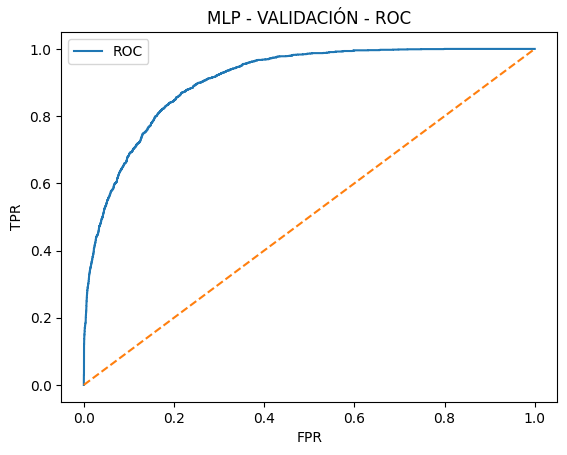

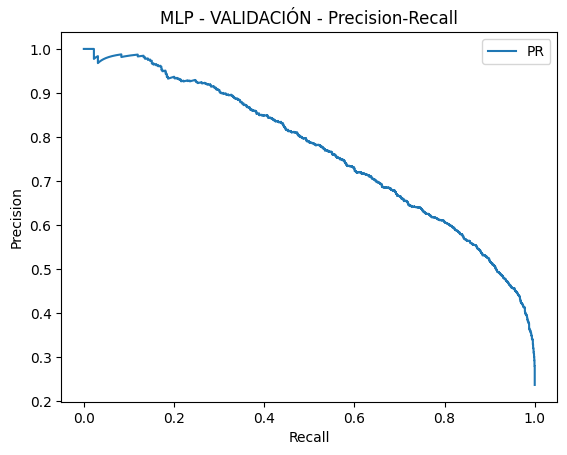


=== MLP - EVALUACIÓN EN TEST ===

=== MLP - TEST (0.5) @thr=0.500 ===
Accuracy : 0.8028
Precision: 0.5518
Recall   : 0.8814
F1       : 0.6787
ROC AUC  : 0.9139

Matriz de confusión:
[[4840 1377]
 [ 228 1695]]

=== MLP - TEST (thr_opt) @thr=0.576 ===
Accuracy : 0.8241
Precision: 0.5900
Recall   : 0.8372
F1       : 0.6922
ROC AUC  : 0.9139

Matriz de confusión:
[[5098 1119]
 [ 313 1610]]


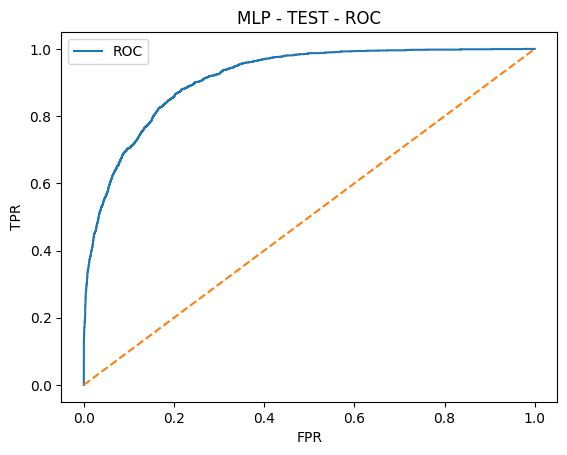

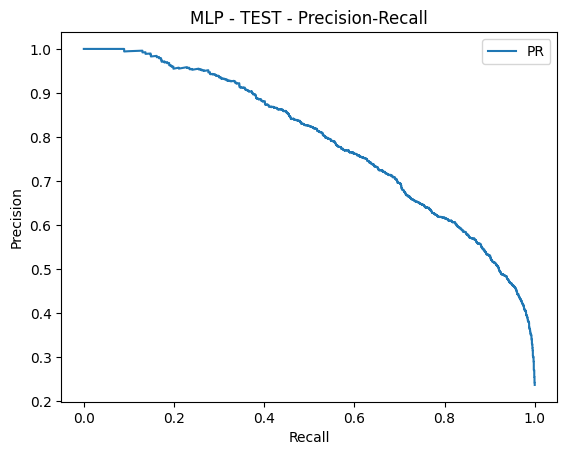

In [14]:
# ============================================
# MLP (PyTorch) para Adult Income
# - EarlyStopping por pérdida en validación
# - Selección de umbral por F1 en validación
# - Reentrenar en Train+Val y evaluar en Test
# ============================================

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Tensores y DataLoaders
# ----------------------------
Xtr_t = torch.tensor(X_train_p, dtype=torch.float32)
ytr_t = torch.tensor(y_train.values, dtype=torch.float32)

Xva_t = torch.tensor(X_val_p, dtype=torch.float32)
yva_t = torch.tensor(y_val.values, dtype=torch.float32)

Xte_t = torch.tensor(X_test_p, dtype=torch.float32)
yte_t = torch.tensor(y_test.values, dtype=torch.float32)

batch_size = 256

train_ds = TensorDataset(Xtr_t, ytr_t)
val_ds   = TensorDataset(Xva_t, yva_t)
test_ds  = TensorDataset(Xte_t, yte_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False)

# ----------------------------
# Modelo MLP
# ----------------------------
in_dim = X_train_p.shape[1]

class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

model = MLP(in_dim).to(device)

# ----------------------------
# Pérdida con pos_weight (clase minoritaria)
# ----------------------------
# pos_weight = (#neg / #pos) para BCEWithLogitsLoss
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
pos_weight = torch.tensor([float(n_neg / max(n_pos, 1))], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)


# ----------------------------
# Entrenamiento + EarlyStopping
# ----------------------------
def run_epoch(loader, model, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)
    total_loss = 0.0
    all_logits = []
    all_targets = []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = model(xb)
        loss = criterion(logits, yb)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        all_logits.append(logits.detach().cpu())
        all_targets.append(yb.detach().cpu())

    avg_loss = total_loss / len(loader.dataset)
    logits = torch.cat(all_logits).numpy()
    targets = torch.cat(all_targets).numpy()
    return avg_loss, logits, targets

best_val_loss = float("inf")
best_state = None
best_epoch = -1
patience = 10
epochs = 100
no_improve = 0

for epoch in range(1, epochs + 1):
    train_loss, _, _ = run_epoch(train_loader, model, criterion, optimizer)
    with torch.no_grad():
        val_loss, val_logits, _ = run_epoch(val_loader, model, criterion, optimizer=None)

    scheduler.step(val_loss)

    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        best_epoch = epoch
        no_improve = 0
    else:
        no_improve += 1

    # print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")
    if no_improve >= patience:
        # print(f"Early stopping en epoch {epoch} (mejor {best_epoch} con val_loss={best_val_loss:.4f})")
        break

# Cargamos el mejor estado
model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
model.eval()

# ----------------------------------------
# Validación: probabilidades y umbral F1
# ----------------------------------------
with torch.no_grad():
    _, val_logits, _ = run_epoch(val_loader, model, criterion, optimizer=None)
val_prob = 1 / (1 + np.exp(-val_logits))  # sigmoid

thr_opt, f1_opt = best_threshold_by_f1(y_val, val_prob)
print(f"\n[MLP] Umbral óptimo por F1 en VALIDACIÓN: thr={thr_opt:.4f}  F1={f1_opt:.4f}")

_ = eval_metrics(y_val, val_prob, threshold=0.5,   title_prefix="MLP - VALIDACIÓN (0.5)")
_ = eval_metrics(y_val, val_prob, threshold=thr_opt, title_prefix="MLP - VALIDACIÓN (thr_opt)")
plot_roc_pr(y_val, val_prob, title_prefix="MLP - VALIDACIÓN")

# --------------------------------------------------------
# Reentrenar en Train+Val por #best_epoch y evaluar Test
# --------------------------------------------------------
# Preparamos DataLoader combinado (sin early stopping aquí; entrenamos best_epoch)
Xtrval = torch.tensor(np.vstack([X_train_p, X_val_p]), dtype=torch.float32)
ytrval = torch.tensor(np.r_[y_train.values, y_val.values], dtype=torch.float32)

trainval_loader = DataLoader(TensorDataset(Xtrval, ytrval), batch_size=batch_size, shuffle=True, drop_last=False)
model_f = MLP(in_dim).to(device)

# Recalcular pos_weight con Train+Val
n_pos_tv = ytrval.sum().item()
n_neg_tv = len(ytrval) - n_pos_tv
pos_weight_tv = torch.tensor([float(n_neg_tv / max(n_pos_tv, 1.0))], dtype=torch.float32).to(device)

criterion_f = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tv)
optimizer_f = torch.optim.Adam(model_f.parameters(), lr=1e-3, weight_decay=1e-4)

for epoch in range(1, best_epoch + 1):
    run_epoch(trainval_loader, model_f, criterion_f, optimizer_f)

model_f.eval()
with torch.no_grad():
    # Probabilidades en Test
    _, test_logits, _ = run_epoch(test_loader, model_f, criterion_f, optimizer=None)
test_prob = 1 / (1 + np.exp(-test_logits))

print("\n=== MLP - EVALUACIÓN EN TEST ===")
_ = eval_metrics(y_test, test_prob, threshold=0.5,   title_prefix="MLP - TEST (0.5)")
_ = eval_metrics(y_test, test_prob, threshold=thr_opt, title_prefix="MLP - TEST (thr_opt)")
plot_roc_pr(y_test, test_prob, title_prefix="MLP - TEST")


In [15]:
# ============================================
# 5 Experimentos comparables (LogReg + 4 MLPs)
# ============================================

PLOT_CURVES = False  # pon True si quieres ver ROC/PR por experimento

# ---------
# Utilidades
# ---------
def stack_train_val(X_train_p, y_train, X_val_p, y_val):
    X_trval = np.vstack([X_train_p, X_val_p])
    y_trval = np.r_[y_train.values, y_val.values]
    return X_trval, y_trval

def mlp_build(in_dim, hidden_layers, dropout):
    layers = []
    prev = in_dim
    for h in hidden_layers:
        layers.append(nn.Linear(prev, h))
        layers.append(nn.ReLU())
        if dropout and dropout > 0:
            layers.append(nn.Dropout(dropout))
        prev = h
    layers.append(nn.Linear(prev, 1))
    return nn.Sequential(*layers)

def mlp_train_val(X_train_p, y_train, X_val_p, y_val,
                  hidden_layers, dropout=0.2,
                  lr=1e-3, weight_decay=1e-4,
                  epochs=100, patience=10, batch_size=256,
                  use_scheduler=True):
    in_dim = X_train_p.shape[1]
    model = mlp_build(in_dim, hidden_layers, dropout).to(device)

    # pos_weight para desbalance
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    pos_weight = torch.tensor([float(n_neg / max(n_pos, 1))], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3) if use_scheduler else None

    # DataLoaders
    Xtr_t = torch.tensor(X_train_p, dtype=torch.float32)
    ytr_t = torch.tensor(y_train.values, dtype=torch.float32)
    Xva_t = torch.tensor(X_val_p, dtype=torch.float32)
    yva_t = torch.tensor(y_val.values, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=batch_size, shuffle=False, drop_last=False)

    def run_epoch(loader, is_train):
        model.train(is_train)
        total_loss, all_logits, all_targets = 0.0, [], []
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb).squeeze(1)
            loss = criterion(logits, yb)
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * xb.size(0)
            all_logits.append(logits.detach().cpu())
            all_targets.append(yb.detach().cpu())
        avg_loss = total_loss / len(loader.dataset)
        logits = torch.cat(all_logits).numpy()
        targets = torch.cat(all_targets).numpy()
        return avg_loss, logits, targets

    best_val_loss = float("inf")
    best_state = None
    best_epoch = -1
    no_improve = 0

    for epoch in range(1, epochs+1):
        train_loss, _, _ = run_epoch(train_loader, is_train=True)
        with torch.no_grad():
            val_loss, val_logits, _ = run_epoch(val_loader, is_train=False)

        if scheduler is not None:
            scheduler.step(val_loss)

        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            # print(f"[MLP] early stopping @ {epoch}, best {best_epoch} (val_loss={best_val_loss:.4f})")
            break

    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    model.eval()

    # Probabilidades en validación y umbral óptimo
    with torch.no_grad():
        _, val_logits, _ = run_epoch(val_loader, is_train=False)
    val_prob = 1 / (1 + np.exp(-val_logits))
    thr_opt, f1_opt = best_threshold_by_f1(y_val, val_prob)

    if PLOT_CURVES:
        plot_roc_pr(y_val, val_prob, title_prefix="MLP - VALIDACIÓN")

    # Métricas validación
    metrics_val_05 = eval_metrics(y_val, val_prob, threshold=0.5,   title_prefix="MLP - VAL (0.5)")
    metrics_val_to = eval_metrics(y_val, val_prob, threshold=thr_opt, title_prefix="MLP - VAL (thr_opt)")

    return model, best_epoch, thr_opt, metrics_val_05, metrics_val_to

def mlp_retrain_test(model_cfg, best_epoch, thr_opt,
                     X_train_p, y_train, X_val_p, y_val, X_test_p, y_test,
                     dropout=0.2, lr=1e-3, weight_decay=1e-4, batch_size=256):
    # Reentrenar en Train+Val por best_epoch
    in_dim = X_train_p.shape[1]
    model_f = mlp_build(in_dim, model_cfg, dropout).to(device)

    X_trval, y_trval = stack_train_val(X_train_p, y_train, X_val_p, y_val)
    X_tv_t = torch.tensor(X_trval, dtype=torch.float32)
    y_tv_t = torch.tensor(y_trval, dtype=torch.float32)
    loader_tv = DataLoader(TensorDataset(X_tv_t, y_tv_t), batch_size=batch_size, shuffle=True, drop_last=False)

    # pos_weight con Train+Val
    n_pos_tv = y_trval.sum()
    n_neg_tv = len(y_trval) - n_pos_tv
    pos_weight_tv = torch.tensor([float(n_neg_tv / max(n_pos_tv, 1.0))], dtype=torch.float32).to(device)
    criterion_f = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tv)
    optimizer_f = torch.optim.Adam(model_f.parameters(), lr=lr, weight_decay=weight_decay)

    def run_epoch_tv():
        model_f.train(True)
        total_loss = 0.0
        for xb, yb in loader_tv:
            xb = xb.to(device); yb = yb.to(device)
            logits = model_f(xb).squeeze(1)
            loss = criterion_f(logits, yb)
            optimizer_f.zero_grad()
            loss.backward()
            optimizer_f.step()
            total_loss += loss.item() * xb.size(0)
        return total_loss / len(loader_tv.dataset)

    for _ in range(best_epoch):
        _ = run_epoch_tv()

    # Test
    X_te_t = torch.tensor(X_test_p, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits_te = model_f(X_te_t).squeeze(1).cpu().numpy()
    test_prob = 1 / (1 + np.exp(-logits_te))

    if PLOT_CURVES:
        plot_roc_pr(y_test, test_prob, title_prefix="MLP - TEST")

    metrics_test_05 = eval_metrics(y_test, test_prob, threshold=0.5,   title_prefix="MLP - TEST (0.5)")
    metrics_test_to = eval_metrics(y_test, test_prob, threshold=thr_opt, title_prefix="MLP - TEST (thr_opt)")
    return metrics_test_05, metrics_test_to

# --------------------------
# Exp. 0: Regresión Logística
# --------------------------
def run_logreg_experiment(X_train_p, y_train, X_val_p, y_val, X_test_p, y_test,
                          C=1.0, class_weight=None, show_importances=False):
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(
        penalty="l2",
        C=C,
        class_weight=class_weight,
        solver="lbfgs",
        max_iter=200,
        n_jobs=None
    )
    clf.fit(X_train_p, y_train)
    yva_prob = clf.predict_proba(X_val_p)[:,1]

    if PLOT_CURVES:
        plot_roc_pr(y_val, yva_prob, title_prefix="LogReg - VALIDACIÓN")

    thr_opt, f1_opt = best_threshold_by_f1(y_val, yva_prob)
    mval05 = eval_metrics(y_val, yva_prob, threshold=0.5,   title_prefix="LogReg - VAL (0.5)")
    mvalto = eval_metrics(y_val, yva_prob, threshold=thr_opt, title_prefix="LogReg - VAL (thr_opt)")

    # Reentrenar en Train+Val
    X_trval, y_trval = stack_train_val(X_train_p, y_train, X_val_p, y_val)
    clf_f = LogisticRegression(
        penalty="l2",
        C=C,
        class_weight=class_weight,
        solver="lbfgs",
        max_iter=200
    )
    clf_f.fit(X_trval, y_trval)
    yte_prob = clf_f.predict_proba(X_test_p)[:,1]

    if PLOT_CURVES:
        plot_roc_pr(y_test, yte_prob, title_prefix="LogReg - TEST")

    mte05 = eval_metrics(y_test, yte_prob, threshold=0.5,   title_prefix="LogReg - TEST (0.5)")
    mteto = eval_metrics(y_test, yte_prob, threshold=thr_opt, title_prefix="LogReg - TEST (thr_opt)")

    # (Opcional) Importancias
    if show_importances and 'final_feature_names' in globals():
        import pandas as pd
        coefs = pd.Series(clf_f.coef_.ravel(), index=final_feature_names).sort_values()
        print("\n[LogReg] Top (+) >50K:")
        print(coefs.tail(15))
        print("\n[LogReg] Top (-) <=50K:")
        print(coefs.head(15))

    return thr_opt, mval05, mvalto, mte05, mteto

# --------------------------
# Lanzar los 5 experimentos
# --------------------------
results = []

# Exp. 0: LogReg baseline (balanced vs none – elige uno; aquí uso 'balanced')
thr0, lr_val05, lr_valto, lr_te05, lr_teto = run_logreg_experiment(
    X_train_p, y_train, X_val_p, y_val, X_test_p, y_test,
    C=1.0, class_weight="balanced", show_importances=False
)
results.append({
    "exp":"LogReg (C=1.0, balanced)",
    "thr_opt":thr0,
    "VAL_acc":lr_valto["acc"], "VAL_prec":lr_valto["prec"], "VAL_rec":lr_valto["rec"], "VAL_f1":lr_valto["f1"], "VAL_auc":lr_valto["auc"],
    "TEST_acc":lr_teto["acc"], "TEST_prec":lr_teto["prec"], "TEST_rec":lr_teto["rec"], "TEST_f1":lr_teto["f1"], "TEST_auc":lr_teto["auc"]
})

# MLP configs
mlp_cfgs = [
    {"name":"MLP [64] d=0.0",          "hidden":[64],       "dropout":0.0, "lr":1e-3, "wd":1e-4},
    {"name":"MLP [128,64] d=0.2",      "hidden":[128,64],   "dropout":0.2, "lr":1e-3, "wd":1e-4},
    {"name":"MLP [256,128] d=0.5",     "hidden":[256,128],  "dropout":0.5, "lr":1e-3, "wd":1e-4},
    {"name":"MLP [256,128] d=0.2 wd1e-3","hidden":[256,128],"dropout":0.2, "lr":1e-3, "wd":1e-3},
]

for cfg in mlp_cfgs:
    print(f"\n=== {cfg['name']} ===")
    model, best_epoch, thr_opt, v05, vto = mlp_train_val(
        X_train_p, y_train, X_val_p, y_val,
        hidden_layers=cfg["hidden"],
        dropout=cfg["dropout"],
        lr=cfg["lr"], weight_decay=cfg["wd"],
        epochs=100, patience=10, batch_size=256,
        use_scheduler=True
    )
    te05, teto = mlp_retrain_test(
        cfg["hidden"], best_epoch, thr_opt,
        X_train_p, y_train, X_val_p, y_val, X_test_p, y_test,
        dropout=cfg["dropout"], lr=cfg["lr"], weight_decay=cfg["wd"], batch_size=256
    )
    results.append({
        "exp":cfg["name"] + f" (best_epoch={best_epoch})",
        "thr_opt":thr_opt,
        "VAL_acc":vto["acc"], "VAL_prec":vto["prec"], "VAL_rec":vto["rec"], "VAL_f1":vto["f1"], "VAL_auc":vto["auc"],
        "TEST_acc":teto["acc"], "TEST_prec":teto["prec"], "TEST_rec":teto["rec"], "TEST_f1":teto["f1"], "TEST_auc":teto["auc"]
    })

# --------------------------
# Tabla comparativa final
# --------------------------
import pandas as pd
df_res = pd.DataFrame(results)
cols = ["exp","thr_opt","VAL_auc","VAL_f1","VAL_prec","VAL_rec","VAL_acc","TEST_auc","TEST_f1","TEST_prec","TEST_rec","TEST_acc"]
df_res = df_res[cols].sort_values(by=["TEST_f1","TEST_auc"], ascending=False).reset_index(drop=True)
print("\n=== RESULTADOS COMPARATIVOS (ordenado por TEST F1, AUC) ===")
display(df_res)



=== LogReg - VAL (0.5) @thr=0.500 ===
Accuracy : 0.8050
Precision: 0.5585
Recall   : 0.8336
F1       : 0.6689
ROC AUC  : 0.9007

Matriz de confusión:
[[4950 1267]
 [ 320 1603]]

=== LogReg - VAL (thr_opt) @thr=0.636 ===
Accuracy : 0.8385
Precision: 0.6393
Recall   : 0.7254
F1       : 0.6797
ROC AUC  : 0.9007

Matriz de confusión:
[[5430  787]
 [ 528 1395]]

=== LogReg - TEST (0.5) @thr=0.500 ===
Accuracy : 0.8060
Precision: 0.5591
Recall   : 0.8466
F1       : 0.6734
ROC AUC  : 0.9064

Matriz de confusión:
[[4933 1284]
 [ 295 1628]]

=== LogReg - TEST (thr_opt) @thr=0.636 ===
Accuracy : 0.8389
Precision: 0.6366
Recall   : 0.7415
F1       : 0.6851
ROC AUC  : 0.9064

Matriz de confusión:
[[5403  814]
 [ 497 1426]]

=== MLP [64] d=0.0 ===

=== MLP - VAL (0.5) @thr=0.500 ===
Accuracy : 0.8092
Precision: 0.5644
Recall   : 0.8430
F1       : 0.6761
ROC AUC  : 0.9071

Matriz de confusión:
[[4966 1251]
 [ 302 1621]]

=== MLP - VAL (thr_opt) @thr=0.574 ===
Accuracy : 0.8289
Precision: 0.6040
Rec

,exp,thr_opt,VAL_auc,VAL_f1,VAL_prec,VAL_rec,VAL_acc,TEST_auc,TEST_f1,TEST_prec,TEST_rec,TEST_acc
0,MLP [64] d=0.0 (best_epoch=8),0.574134,0.907108,0.688437,0.604003,0.800312,0.828870,0.913590,0.699180,0.622312,0.797712,0.837838
1,"MLP [256,128] d=0.2 wd1e-3 (best_epoch=27)",0.607209,0.909829,0.692290,0.618056,0.786791,0.834767,0.914196,0.696977,0.619144,0.797192,0.836241
2,"MLP [128,64] d=0.2 (best_epoch=7)",0.603525,0.908202,0.693223,0.619223,0.787311,0.835381,0.911757,0.694189,0.610497,0.804472,0.832555
3,"MLP [256,128] d=0.5 (best_epoch=12)",0.580899,0.908296,0.689532,0.603039,0.804992,0.828747,0.910902,0.691363,0.590074,0.834633,0.823956
4,"LogReg (C=1.0, balanced)",0.635714,0.900676,0.679659,0.639322,0.725429,0.838452,0.906386,0.685083,0.636607,0.741550,0.838943


In [16]:
# ===============================================
# (4) Mejor MLP con REGULARIZACIÓN + métricas T/V/Te
# ===============================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# ----- utilidades locales -----
def mlp_build(in_dim, hidden_layers, dropout):
    layers = []
    prev = in_dim
    for h in hidden_layers:
        layers.append(nn.Linear(prev, h))
        layers.append(nn.ReLU())
        if dropout and dropout > 0:
            layers.append(nn.Dropout(dropout))
        prev = h
    layers.append(nn.Linear(prev, 1))
    return nn.Sequential(*layers)

def train_val_mlp_once(X_train_p, y_train, X_val_p, y_val,
                       hidden_layers, dropout, lr, weight_decay,
                       epochs=100, patience=10, batch_size=256, use_scheduler=True):
    """Entrena una sola configuración y devuelve:
       - model (en mejor estado)
       - best_epoch, thr_opt
       - y_prob en Train y Validación
       - métricas en Validación (0.5 y thr_opt)
    """
    in_dim = X_train_p.shape[1]
    model = mlp_build(in_dim, hidden_layers, dropout).to(device)

    # pos_weight para desbalance
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    pos_weight = torch.tensor([float(n_neg / max(n_pos, 1))], dtype=torch.float32).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3) if use_scheduler else None

    # Data
    Xtr_t = torch.tensor(X_train_p, dtype=torch.float32)
    ytr_t = torch.tensor(y_train.values, dtype=torch.float32)
    Xva_t = torch.tensor(X_val_p, dtype=torch.float32)
    yva_t = torch.tensor(y_val.values, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=batch_size, shuffle=False, drop_last=False)

    def run_epoch(loader, train_flag):
        model.train(train_flag)
        tot, logits_list, y_list = 0.0, [], []
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb).squeeze(1)
            loss = criterion(logits, yb)
            if train_flag:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            tot += loss.item() * xb.size(0)
            logits_list.append(logits.detach().cpu())
            y_list.append(yb.detach().cpu())
        avg = tot / len(loader.dataset)
        logits = torch.cat(logits_list).numpy()
        y_true = torch.cat(y_list).numpy()
        return avg, logits, y_true

    # Early stopping
    best_val, best_state, best_epoch, no_imp = float("inf"), None, -1, 0
    for ep in range(1, epochs+1):
        tr_loss, _, _ = run_epoch(train_loader, True)
        with torch.no_grad():
            va_loss, va_logits, _ = run_epoch(val_loader, False)
        if scheduler is not None:
            scheduler.step(va_loss)
        if va_loss < best_val - 1e-6:
            best_val = va_loss
            best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
            best_epoch = ep
            no_imp = 0
        else:
            no_imp += 1
        if no_imp >= patience:
            break

    # cargar mejor estado
    model.load_state_dict({k: v.to(device) for k,v in best_state.items()})
    model.eval()

    # probs en TRAIN/VAL con ese mejor estado (para métricas comparables)
    with torch.no_grad():
        _, tr_logits, ytr_true = run_epoch(train_loader, False)
        _, va_logits, yva_true = run_epoch(val_loader, False)
    tr_prob = 1 / (1 + np.exp(-tr_logits))
    va_prob = 1 / (1 + np.exp(-va_logits))

    # umbral en validación
    thr_opt, f1_opt = best_threshold_by_f1(y_val, va_prob)

    # métricas en validación
    m_val_05 = eval_metrics(y_val, va_prob, threshold=0.5,   title_prefix="VAL (0.5)")
    m_val_to = eval_metrics(y_val, va_prob, threshold=thr_opt, title_prefix="VAL (thr_opt)")

    return model, best_epoch, thr_opt, tr_prob, va_prob, m_val_05, m_val_to

def retrain_on_trainval_and_test(cfg, best_epoch, thr_opt,
                                 X_train_p, y_train, X_val_p, y_val, X_test_p, y_test):
    """Reentrena en Train+Val por best_epoch y evalúa en Test."""
    in_dim = X_train_p.shape[1]
    model_f = mlp_build(in_dim, cfg["hidden_layers"], cfg["dropout"]).to(device)

    X_trval = np.vstack([X_train_p, X_val_p])
    y_trval = np.r_[y_train.values, y_val.values]

    # DataLoader Train+Val
    X_tv_t = torch.tensor(X_trval, dtype=torch.float32)
    y_tv_t = torch.tensor(y_trval, dtype=torch.float32)
    loader_tv = DataLoader(TensorDataset(X_tv_t, y_tv_t), batch_size=cfg.get("batch_size",256), shuffle=True, drop_last=False)

    # pos_weight con Train+Val
    n_pos_tv = y_trval.sum()
    n_neg_tv = len(y_trval) - n_pos_tv
    pos_weight_tv = torch.tensor([float(n_neg_tv / max(n_pos_tv, 1.0))], dtype=torch.float32).to(device)

    crit = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tv)
    opt  = torch.optim.Adam(model_f.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

    # entrenar por best_epoch
    for _ in range(best_epoch):
        model_f.train(True)
        for xb, yb in loader_tv:
            xb = xb.to(device); yb = yb.to(device)
            logits = model_f(xb).squeeze(1)
            loss = crit(logits, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()

    # Test
    Xte_t = torch.tensor(X_test_p, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits_te = model_f(Xte_t).squeeze(1).cpu().numpy()
    te_prob = 1 / (1 + np.exp(-logits_te))

    m_te_05 = eval_metrics(y_test, te_prob, threshold=0.5,   title_prefix="TEST (0.5)")
    m_te_to = eval_metrics(y_test, te_prob, threshold=thr_opt, title_prefix="TEST (thr_opt)")
    return te_prob, m_te_05, m_te_to

# -----------------------------------------
# Grid de REGULARIZACIÓN (dropout, weight_decay)
# -----------------------------------------
grid = [
    {"hidden_layers":[128,64],  "dropout":0.2, "lr":1e-3, "weight_decay":1e-4, "batch_size":256},
    {"hidden_layers":[128,64],  "dropout":0.3, "lr":1e-3, "weight_decay":5e-4, "batch_size":256},
    {"hidden_layers":[256,128], "dropout":0.2, "lr":1e-3, "weight_decay":1e-4, "batch_size":256},
    {"hidden_layers":[256,128], "dropout":0.2, "lr":1e-3, "weight_decay":1e-3, "batch_size":256},
    {"hidden_layers":[256,128], "dropout":0.5, "lr":1e-3, "weight_decay":1e-4, "batch_size":256},
]

results = []
best_item = None

for i, cfg in enumerate(grid, 1):
    print(f"\n=== REG-SEARCH {i}/{len(grid)}: {cfg} ===")
    model, best_epoch, thr_opt, tr_prob, va_prob, mval05, mvalto = train_val_mlp_once(
        X_train_p, y_train, X_val_p, y_val,
        hidden_layers=cfg["hidden_layers"],
        dropout=cfg["dropout"],
        lr=cfg["lr"],
        weight_decay=cfg["weight_decay"],
        epochs=100, patience=10, batch_size=cfg["batch_size"], use_scheduler=True
    )
    # criterio de selección: primero AUC_val (thr_opt no afecta AUC), luego F1_val@thr_opt
    sel_score = (mvalto["auc"], mvalto["f1"])
    results.append({"cfg":cfg, "best_epoch":best_epoch, "thr_opt":thr_opt, "mval_to":mvalto, "mval_05":mval05, "sel":sel_score})
    if (best_item is None) or (sel_score > best_item["sel"]):
        best_item = results[-1]
        best_item["model"] = model

print("\n>>> MEJOR CONFIG (por AUC_val, luego F1_val):")
print(best_item["cfg"], " | best_epoch=", best_item["best_epoch"], " | thr_opt=", round(best_item["thr_opt"],4))
print("VAL metrics @thr_opt:", best_item["mval_to"])

# -----------------------------------------
# (7) Métricas en TRAIN / VALIDACIÓN / TEST
# -----------------------------------------
# Con el modelo entrenado en Train (mejor estado), usamos el thr_opt de validación:
best_cfg     = best_item["cfg"]
best_epoch   = best_item["best_epoch"]
thr_opt      = best_item["thr_opt"]
best_model   = best_item["model"]

# Probabilidades en TRAIN y VALIDACIÓN ya las teníamos dentro de la función,
# pero para claridad las recalculamos aquí con el mejor_modelo (no afecta)
with torch.no_grad():
    Xtr_t = torch.tensor(X_train_p, dtype=torch.float32).to(device)
    Xva_t = torch.tensor(X_val_p,   dtype=torch.float32).to(device)
    tr_prob = 1 / (1 + np.exp(-best_model(Xtr_t).squeeze(1).cpu().numpy()))
    va_prob = 1 / (1 + np.exp(-best_model(Xva_t).squeeze(1).cpu().numpy()))

print("\n=== MÉTRICAS (usando thr_opt de Validación) ===")
m_train = eval_metrics(y_train, tr_prob, threshold=thr_opt, title_prefix="TRAIN (thr_opt)")
m_val   = eval_metrics(y_val,   va_prob, threshold=thr_opt, title_prefix="VAL (thr_opt)")

# Reentrenar en Train+Val por best_epoch y evaluar en Test
te_prob, m_test_05, m_test_to = retrain_on_trainval_and_test(
    best_cfg, best_epoch, thr_opt,
    X_train_p, y_train, X_val_p, y_val, X_test_p, y_test
)

# --------- resumen final en dict / DataFrame ----------
import pandas as pd
summary = pd.DataFrame([
    {"split":"TRAIN","acc":m_train["acc"],"prec":m_train["prec"],"rec":m_train["rec"],"f1":m_train["f1"],"auc":m_train["auc"],"threshold":thr_opt},
    {"split":"VAL","acc":m_val["acc"],"prec":m_val["prec"],"rec":m_val["rec"],"f1":m_val["f1"],"auc":m_val["auc"],"threshold":thr_opt},
    {"split":"TEST@0.5","acc":m_test_05["acc"],"prec":m_test_05["prec"],"rec":m_test_05["rec"],"f1":m_test_05["f1"],"auc":m_test_05["auc"],"threshold":0.5},
    {"split":"TEST@thr_opt","acc":m_test_to["acc"],"prec":m_test_to["prec"],"rec":m_test_to["rec"],"f1":m_test_to["f1"],"auc":m_test_to["auc"],"threshold":thr_opt},
])
print("\n=== RESUMEN MÉTRICAS (Mejor MLP con regularización) ===")
display(summary)





=== REG-SEARCH 1/5: {'hidden_layers': [128, 64], 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 256} ===

=== VAL (0.5) @thr=0.500 ===
Accuracy : 0.8124
Precision: 0.5690
Recall   : 0.8487
F1       : 0.6813
ROC AUC  : 0.9088

Matriz de confusión:
[[4981 1236]
 [ 291 1632]]

=== VAL (thr_opt) @thr=0.566 ===
Accuracy : 0.8308
Precision: 0.6072
Recall   : 0.8040
F1       : 0.6919
ROC AUC  : 0.9088

Matriz de confusión:
[[5217 1000]
 [ 377 1546]]

=== REG-SEARCH 2/5: {'hidden_layers': [128, 64], 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.0005, 'batch_size': 256} ===

=== VAL (0.5) @thr=0.500 ===
Accuracy : 0.8103
Precision: 0.5651
Recall   : 0.8554
F1       : 0.6806
ROC AUC  : 0.9088

Matriz de confusión:
[[4951 1266]
 [ 278 1645]]

=== VAL (thr_opt) @thr=0.601 ===
Accuracy : 0.8322
Precision: 0.6122
Recall   : 0.7904
F1       : 0.6900
ROC AUC  : 0.9088

Matriz de confusión:
[[5254  963]
 [ 403 1520]]

=== REG-SEARCH 3/5: {'hidden_layers': [256, 128], 'dropout': 0.

,split,acc,prec,rec,f1,auc,threshold
0,TRAIN,0.836338,0.616512,0.847596,0.713818,0.923751,0.560354
1,VAL,0.825799,0.595971,0.815393,0.688625,0.909113,0.560354
2,TEST@0.5,0.814005,0.570639,0.859074,0.685762,0.912435,0.500000
3,TEST@thr_opt,0.828747,0.600227,0.823713,0.694432,0.912435,0.560354
